<a href="https://colab.research.google.com/github/serinamarie/DS-Unit-2-Applied-Modeling/blob/master/Unit_2_Sprint_3_Assignments_1_and_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
df = pd.read_csv('SpeedDatingData.csv')
#Link to dataset: http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [25]:
df.shape

(8378, 195)

In [0]:
#Understand how the experiment was performed and make intuitive connections

In [0]:
target = 'dec'
#target = 'match'

In [0]:
#4448 observations
#Because there are variations in the experiments, it seems best
#to do a random train/val/test
#There are so many nulls so we'll have to drop some columns
#This is a problem of classification
#Evaluation metric - unsure
#Baseline majority for gender
#May have to exclude some features because of high null counts


In [28]:
df[target].value_counts()

0    4860
1    3518
Name: dec, dtype: int64

In [29]:
y_true = df[target]
majority = df[target].mode()[0]

y_pred = [majority] * len(y_true)

from sklearn.metrics import accuracy_score
print("Baseline Accuracy:", accuracy_score(y_true, y_pred))

Baseline Accuracy: 0.5800907137741704


In [30]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=target)
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    train_size=0.8,
    stratify=y,
    random_state=8
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6702, 194), (1676, 194), (6702,), (1676,))

In [0]:
def wrangle(X):

    #So there's no copy warning
    X = X.copy()

    #Unimportant columns - specific to the event that was attended
    #and multiple of the same id or partner exist for completely different people
    unimportant = ['id', 'partner', 'undergra', 'mn_sat', 'zipcode']
    X = X.drop(columns=unimportant)

    #Too many nulls (57% of tuition is null)
    null_full = ['tuition', 'attr7_2', 'sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2', 'shar7_2']  
    X = X.drop(columns=null_full)

    #Remove commas
    X['income'] = X['income'].str.replace(',','').astype(float)

    #oracle info - too much info about target
    oracle = ['match', 'like','dec_o']
    X = X.drop(columns=oracle)

    #post-event: data from after event is full of nulls and may leak data about target
    post_event = [ 'you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3', 'attr1_3', 
                  'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3', 'shar1_3', 'attr7_3', 'sinc7_3',
                  'intel7_3', 'fun7_3', 'amb7_3', 'shar7_3', 'attr4_3', 'sinc4_3',
                  'intel4_3', 'fun4_3', 'amb4_3', 'shar4_3', 'attr2_3', 'sinc2_3',
                  'intel2_3', 'fun2_3', 'amb2_3', 'shar2_3', 'attr3_3', 'sinc3_3',
                  'intel3_3', 'fun3_3', 'amb3_3', 'attr5_3', 'sinc5_3', 'intel5_3',
                  'fun5_3', 'amb5_3']
    X = X.drop(columns=post_event)
    return X


In [32]:
X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_train.shape

(6702, 140)

In [0]:
#Before getting rid of more high-null columns, try fitting a pipeline on model
#and validating

##FeatureImportance

In [0]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def modelfit(alg, training_data, predictors, performCV=True, 
    printFeatureImportance=True, cv_folds=5):
    #Fit estimator on data
    alg.fit(training_data[predictors], training_data[target])

    #Predict with training set
    train_pred = alg.predict(training_data[predictors])
    train_predprob = alg.predict_proba(training_data[predictors])[:,1]

    #Perform cross_val
    if performCV:
        cv_score = cross_val_score(
            alg, training_data[predictors], training_data[target], 
            cv=cv_folds, scoring='accuracy')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy: %.4g" % accuracy_score(training_data[target].values, train_pred))

    if performCV:
        print("CV Score: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    #Print feature importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.steps[2][1].feature_importances_, alg.steps[0][1].get_feature_names()).sort_values(ascending=False)[:30]
        feat_imp.plot(kind='bar', title='Feature Importance')
        plt.ylabel('Feature Importance Score')

In [35]:
#Create a pipeline detailing what we want to do to this data
!pip install category_encoders 

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

pipeline1 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=8, n_jobs=-1)
)


Model Report
Accuracy: 0.8397
CV Score: Mean - 0.8045361 | Std - 0.011247 | Min - 0.7837435 | Max - 0.8165548


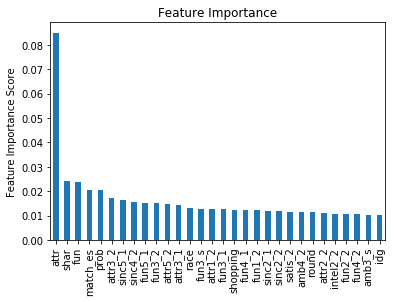

In [36]:
#Looks like, as expected, the more the actor considered their speed-date partner 
#to be attractive, they were MUCH more likely to make a 'dec' (decision) of yes 
predictors = [x for x in X_train.columns]
training_data = X_train.join(y_train)
modelfit(pipeline1, 
         training_data,
         predictors)

In [37]:
pipeline1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['field', 'from', 'career'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'field',
                                          'data_type': dtype('O'),
                                          'mapping': Electrical Engineering                                        1
Psychology                                                    2
International Politics                                        3
Classics                                                      4
International Affairs                                         5
Film                                                          6
MBA                                                           7
electrical engineering                                        8
Conservation biolog...
                 XGBClassifier

In [38]:
y_pred = pipeline1.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Validation Accuracy: 0.8144391408114559


##PermutationImportance

In [0]:
#Pipelines don't work with eli5 permutationimportance,
#so fit it before permutation
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

In [45]:
model = XGBClassifier(n_estimators=200, random_state=8, n_job=-1)
model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_job=-1,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=8, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [47]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=8
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.1029 ± 0.0066,attr
0.0230 ± 0.0066,match_es
0.0182 ± 0.0149,prob
0.0140 ± 0.0125,fun
0.0051 ± 0.0006,attr3_1
0.0051 ± 0.0054,shar1_1
0.0033 ± 0.0006,shar4_1
0.0033 ± 0.0042,shar2_1
0.0030 ± 0.0024,imprelig
0.0027 ± 0.0018,fun3_s


In [74]:
from sklearn.ensemble import AdaBoostClassifier

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train.shape, X_val.shape, X_train_encoded.shape, X_val_encoded.shape

((6702, 140), (1676, 140), (6702, 140), (1676, 140))

In [0]:
eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

In [77]:
model = XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.1,
    n_jobs = -1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, eval_metric='auc', early_stopping_rounds=50)

[0]	validation_0-auc:0.887666	validation_1-auc:0.854906
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.911084	validation_1-auc:0.882614
[2]	validation_0-auc:0.917183	validation_1-auc:0.886055
[3]	validation_0-auc:0.925433	validation_1-auc:0.88881
[4]	validation_0-auc:0.931385	validation_1-auc:0.890105
[5]	validation_0-auc:0.935951	validation_1-auc:0.891233
[6]	validation_0-auc:0.941276	validation_1-auc:0.895664
[7]	validation_0-auc:0.943845	validation_1-auc:0.896237
[8]	validation_0-auc:0.946818	validation_1-auc:0.898517
[9]	validation_0-auc:0.949146	validation_1-auc:0.897724
[10]	validation_0-auc:0.952053	validation_1-auc:0.897649
[11]	validation_0-auc:0.955581	validation_1-auc:0.899121
[12]	validation_0-auc:0.957921	validation_1-auc:0.899337
[13]	validation_0-auc:0.960743	validation_1-auc:0.90192
[14]	validation_0-auc:0.961944	validation_1-auc:0.902299


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

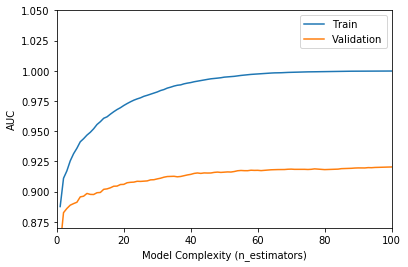

In [94]:
results= model.evals_result()
train_auc = results['validation_0']['auc']
val_auc = results['validation_1']['auc']
epoch = range(1, len(train_auc)+1)
plt.plot(epoch, train_auc, label='Train')
plt.plot(epoch, val_auc, label='Validation')
plt.ylabel("AUC")
plt.xlabel("Model Complexity (n_estimators)")
plt.xlim(0,100)
plt.ylim(0.87,1.05)
plt.legend();
#60 estimators~

In [51]:
print("Validation Accuracy", pipeline2.score(X_val, y_val))
y_pred = pipeline2.predict(X_val)

Validation Accuracy 0.8192124105011933


In [95]:
from sklearn.metrics import confusion_matrix, recall_score

confusion_matrix(y_val, y_pred)

array([[830, 142],
       [161, 543]])

In [96]:
recall_score(y_val, y_pred)

0.7713068181818182